In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

For simplicity we are going to define a symmetrical uniform grid from $-3$ to $3$ both on $x$ and $y$, with step size $1$.

In [2]:
GRID_MIN = -3
GRID_MAX = 3
STEP_SIZE = 1

In [3]:
RADIUS = 2.5

In [4]:
def circle_function(x: float, y: float, r: float = RADIUS) -> float:
    """Calculates the distance from the point `(x, y)` to the center
    of the circle `(0, 0)` with radius `r`.

    Args:
        x (float): x coordinate of the point
        y (float): y coordinate of the point
        r (float, optional): Radius of the circle. Defaults to 2.5.

    Returns:
        float: Distance from the point `(x, y)` to the center
    of the circle `(0, 0)` with radius `r`
    """
    return r - math.sqrt(x**2 + y**2)

In [5]:
def is_inside(val):
    return val > 0

In [6]:
def define_input():
    grid_cells = {}
    x_edges = np.arange(GRID_MIN, GRID_MAX + STEP_SIZE, STEP_SIZE)
    y_edges = np.arange(GRID_MIN, GRID_MAX + STEP_SIZE, STEP_SIZE)
    # we should iterate over each cell
    for i in range(len(x_edges)-STEP_SIZE):
        for j in range(len(y_edges)-STEP_SIZE):
            intersections = []
            normals = []
            # first for each cell edge determine the sign
            ll = circle_function(x_edges[i], y_edges[j])
            lr = circle_function(x_edges[i + 1], y_edges[j])
            ul = circle_function(x_edges[i], y_edges[j + 1])
            ur = circle_function(x_edges[i + 1], y_edges[j + 1])


            if is_inside(ll) != is_inside(lr):
                x_val = np.sqrt(RADIUS**2 - y_edges[j]**2)
                if x_edges[i] <= x_val <= x_edges[i + 1]:
                    intersections.append((x_val, y_edges[j]))
                if x_edges[i] <= -x_val <= x_edges[i + 1]:
                    intersections.append((-x_val, y_edges[j]))

            if is_inside(ll) != is_inside(ul):
                y_val = np.sqrt(RADIUS**2 - x_edges[i]**2)
                if y_edges[j] <= y_val <= y_edges[j + 1]:
                    intersections.append((x_edges[i], y_val))
                if y_edges[j] <= -y_val <= y_edges[j + 1]:
                    intersections.append((x_edges[i], -y_val))
                
            if is_inside(ur) != is_inside(ul):
                x_val = np.sqrt(RADIUS**2 - y_edges[j + 1]**2)
                if x_edges[i] <= x_val <= x_edges[i + 1]:
                    intersections.append((x_val, y_edges[j + 1]))
                if x_edges[i] <= -x_val <= x_edges[i + 1]:
                    intersections.append((-x_val, y_edges[j + 1]))

            if is_inside(ur) != is_inside(lr):
                y_val = np.sqrt(RADIUS**2 - x_edges[i + 1]**2)
                if y_edges[j] <= y_val <= y_edges[j + 1]:
                    intersections.append((x_edges[i + 1], y_val))
                if y_edges[j] <= -y_val <= y_edges[j + 1]:
                    intersections.append((x_edges[i + 1], -y_val))
        
            normals = [-np.array(n) / np.linalg.norm(n) for n in intersections]
            grid_cells[(i, j)] = {'intersections': intersections, 'normals': normals}
    
    return grid_cells

In [7]:
def qef(cells):
    vertices = {}
    for (i, j), data in cells.items():
        if len(data['intersections']) == 0:
            continue
        
        # Build A and b for least squares
        A = np.zeros((2, 2))
        b = np.zeros(2)
        
        for (x, y), n in zip(data['intersections'], data['normals']):
            nx, ny = n
            A += np.outer([nx, ny], [nx, ny]) # This is actually A^T.A, producing a 2 by 2 matrix in the end
            scalar = nx * x + ny * y # This is the scalar b from the paper
            b += scalar * np.array([nx, ny]) # This is A^T.b from the paper
        
        # Regularize if singular
        epsilon = 1e-8
        A += epsilon * np.eye(2)
        
        # we should solve A*x = b for the matrices we just constructed 
        try:
            v = np.linalg.solve(A, b)
            vertices[(i, j)] = v
        except np.linalg.LinAlgError:
            pass
    
    return vertices

In [8]:
def define_edges(vertices):
    edges = []
    # Check horizontal connections (shared vertical edges)
    for i in range(int((GRID_MAX - GRID_MIN)/STEP_SIZE)):
        for j in range(int((GRID_MAX - GRID_MIN)/STEP_SIZE)):
            if (i, j) in vertices and (i+1, j) in vertices:
                edges.append([vertices[(i, j)], vertices[(i+1, j)]])
    
    # Check vertical connections (shared horizontal edges)
    for i in range(int((GRID_MAX - GRID_MIN)/STEP_SIZE)):
        for j in range(int((GRID_MAX - GRID_MIN)/STEP_SIZE)):
            if (i, j) in vertices and (i, j+1) in vertices:
                edges.append([vertices[(i, j)], vertices[(i, j+1)]])
    
    return edges

In [9]:
cells = define_input()
vertices = qef(cells)
edges = define_edges(vertices)

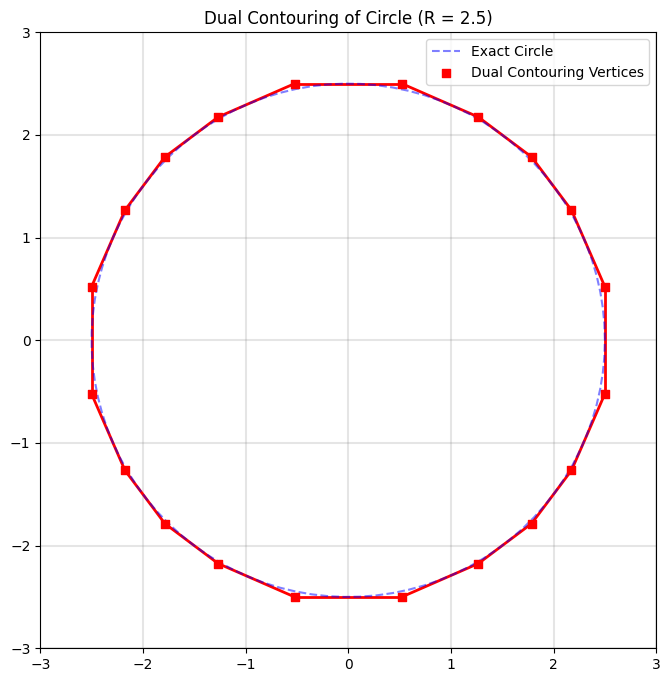

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Plot grid
for x in np.arange(GRID_MIN, GRID_MAX + STEP_SIZE, STEP_SIZE):
    ax.axvline(x, color='gray', alpha=0.2)
    ax.axhline(x, color='gray', alpha=0.2)
# for y in np.arange(GRID_MIN, GRID_MAX + STEP_SIZE, STEP_SIZE):
#     ax.axhline(y, color='gray', alpha=0.2)

# Plot dual contouring edges
if edges:
    lc = LineCollection(edges, colors='red', linewidths=2)
    ax.add_collection(lc)

# Plot exact circle for comparison
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(RADIUS * np.cos(theta), RADIUS * np.sin(theta), 
        '--', color='blue', alpha=0.5, label='Exact Circle')

# Plot vertices
if vertices:
    vx, vy = zip(*vertices.values())
    ax.scatter(vx, vy, color='red', s=40, zorder=3, label='Dual Contouring Vertices', marker="s")

ax.set_xlim(GRID_MIN, GRID_MAX)
ax.set_ylim(GRID_MIN, GRID_MAX)
ax.legend()
plt.title(f"Dual Contouring of Circle (R = {RADIUS})")
plt.show()